# Demand forecasting with the Temporal Fusion Transformer


In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import sympy

In [5]:
path = os.getcwd() + '/docs/source/tutorials/project_data/'

## Load data


In [6]:
data = pd.read_csv(path+'MiningProcess_Flotation_Plant_Database_hourly.csv', index_col=0)
data = data.drop(['time_idx', 'hour'],axis=1)
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.20,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,...,250.208184,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31
1,55.20,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,...,249.897572,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11
2,55.20,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,...,250.484183,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27
3,55.20,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,250.120861,...,250.157622,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36
4,55.20,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,250.013500,...,250.078639,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,49.75,23.20,3327.047776,497.211189,380.847200,9.176166,1.660871,301.565561,300.169133,299.900722,...,298.736661,397.781583,498.753311,403.858956,398.930467,502.971728,399.468911,400.559511,65.05,1.65
4093,49.75,23.20,4225.800333,508.963856,381.112889,9.387541,1.691996,300.050172,299.967839,299.906550,...,303.599269,399.928567,499.648950,399.208611,399.967122,501.624533,398.905006,400.486233,64.83,1.71
4094,49.75,23.20,2808.214692,517.748822,381.064411,9.771277,1.735647,299.814289,299.801561,299.973161,...,309.875439,399.961433,500.484917,471.827489,399.931033,500.223311,401.899806,400.556333,64.29,1.80
4095,49.75,23.20,3191.497672,492.511228,380.445006,9.782121,1.716644,300.122756,299.679472,299.927028,...,305.254558,399.601383,498.614494,836.277192,400.455389,500.406239,402.703283,401.769072,64.25,1.96


In [7]:
data = pd.read_csv(path+'MiningProcess_Flotation_Plant_Database_hourly.csv', index_col=0)
data['Starch Flow'].mean()

2869.1420086031835

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4097 entries, 0 to 4096
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   time_idx                      4097 non-null   int64  
 1   hour                          4097 non-null   int64  
 2   % Iron Feed                   4097 non-null   float64
 3   % Silica Feed                 4097 non-null   float64
 4   Starch Flow                   4097 non-null   float64
 5   Amina Flow                    4097 non-null   float64
 6   Ore Pulp Flow                 4097 non-null   float64
 7   Ore Pulp pH                   4097 non-null   float64
 8   Ore Pulp Density              4097 non-null   float64
 9   Flotation Column 01 Air Flow  4097 non-null   float64
 10  Flotation Column 02 Air Flow  4097 non-null   float64
 11  Flotation Column 03 Air Flow  4097 non-null   float64
 12  Flotation Column 04 Air Flow  4097 non-null   float64
 13  Flo

In [9]:
# plt.figure(figsize=(25,25))
# sns.heatmap(data.corr(), annot=True)
# plt.title('Correlation Matrix')
# plt.show()

In [10]:
X = data.drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
Y = data[['% Iron Concentrate', '% Silica Concentrate']]

In [11]:
X.describe()

,time_idx,hour,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
count,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,...,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000
mean,98.852819,11.507200,56.294730,14.651733,2869.142009,488.145318,397.578386,9.767642,1.680380,280.151579,...,299.917876,292.071096,290.754471,520.244362,522.649044,531.352098,420.321254,425.251991,429.941327,421.021513
std,50.868522,6.925349,5.158347,6.808236,950.480080,83.689937,8.370683,0.378027,0.063775,29.410048,...,3.332540,29.598590,27.219983,122.175617,116.054997,138.588088,76.585553,75.033153,75.507250,72.555295
min,0.000000,0.000000,42.740000,1.310000,54.595483,242.927477,376.837604,8.753389,1.519926,175.885579,...,287.056447,196.512082,199.728122,181.925623,224.909663,135.214506,165.725058,214.735894,203.702926,185.061388
25%,56.000000,5.000000,52.670000,8.940000,2168.968993,436.037967,398.851356,9.540878,1.651352,250.089767,...,299.688506,268.679419,283.155469,416.468100,449.249644,405.366394,351.490017,350.979578,354.128200,350.939278
50%,99.000000,12.000000,56.080000,13.850000,2908.340847,502.454283,399.842656,9.795850,1.695705,299.837839,...,299.923850,299.870378,299.861167,499.619556,499.822467,499.593706,401.272994,401.127639,407.549394,400.988261
75%,143.000000,18.000000,59.720000,19.600000,3528.727412,549.522256,400.589883,10.030779,1.721790,299.951350,...,300.138183,300.095872,300.112433,599.712939,599.331622,600.215106,496.201878,497.775572,497.806211,462.283886
max,185.000000,23.000000,65.780000,33.400000,6270.158798,736.982378,418.070232,10.807370,1.832430,312.295415,...,307.009708,354.979117,351.268656,859.025062,827.775874,884.840698,675.631942,674.068176,698.505832,655.501603


In [12]:
Y.describe()

,% Iron Concentrate,% Silica Concentrate
count,4097.000000,4097.000000
mean,65.050084,2.326754
std,1.118099,1.124783
min,62.050000,0.600000
25%,64.370000,1.440000
50%,65.210000,2.000000
75%,65.860000,3.010000
max,68.010000,5.530000


# Unit root test

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, name) :
    print('Results of Dickey-Fuller Test:', name)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items() :
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
for i in X.columns :
    adf_test(X[i], i)

Results of Dickey-Fuller Test: time_idx
Test Statistic                   -1.631932
p-value                           0.466479
#Lags Used                       24.000000
Number of Observations Used    4072.000000
Critical Value (1%)              -3.431957
Critical Value (5%)              -2.862250
Critical Value (10%)             -2.567148
dtype: float64
Results of Dickey-Fuller Test: hour
Test Statistic                  -21.315676
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    4066.000000
Critical Value (1%)              -3.431959
Critical Value (5%)              -2.862251
Critical Value (10%)             -2.567149
dtype: float64
Results of Dickey-Fuller Test: % Iron Feed
Test Statistic                   -3.840940
p-value                           0.002515
#Lags Used                       24.000000
Number of Observations Used    4072.000000
Critical Value (1%)              -3.431957
Critical Value (5%)              -

Test Statistic                -1.007255e+01
p-value                        1.247885e-17
#Lags Used                     4.000000e+00
Number of Observations Used    4.092000e+03
Critical Value (1%)           -3.431949e+00
Critical Value (5%)           -2.862247e+00
Critical Value (10%)          -2.567146e+00
dtype: float64


In [15]:
adf_test(X['% Iron Feed'], '% Iron Feed')
print()
adf_test(X['% Silica Feed'], '% Silica Feed')

Results of Dickey-Fuller Test: % Iron Feed
Test Statistic                   -3.840940
p-value                           0.002515
#Lags Used                       24.000000
Number of Observations Used    4072.000000
Critical Value (1%)              -3.431957
Critical Value (5%)              -2.862250
Critical Value (10%)             -2.567148
dtype: float64

Results of Dickey-Fuller Test: % Silica Feed
Test Statistic                   -4.540993
p-value                           0.000166
#Lags Used                       27.000000
Number of Observations Used    4069.000000
Critical Value (1%)              -3.431958
Critical Value (5%)              -2.862251
Critical Value (10%)             -2.567148
dtype: float64


In [16]:
adf_test(Y['% Iron Concentrate'], '% Iron Concentrate')
print()
adf_test(Y['% Silica Concentrate'], '% Silica Concentrate')

Results of Dickey-Fuller Test: % Iron Concentrate
Test Statistic                -8.487437e+00
p-value                        1.341426e-13
#Lags Used                     2.400000e+01
Number of Observations Used    4.072000e+03
Critical Value (1%)           -3.431957e+00
Critical Value (5%)           -2.862250e+00
Critical Value (10%)          -2.567148e+00
dtype: float64

Results of Dickey-Fuller Test: % Silica Concentrate
Test Statistic                -8.177803e+00
p-value                        8.286035e-13
#Lags Used                     2.400000e+01
Number of Observations Used    4.072000e+03
Critical Value (1%)           -3.431957e+00
Critical Value (5%)           -2.862250e+00
Critical Value (10%)          -2.567148e+00
dtype: float64


# Stationary test

In [17]:
for i in X.columns :
    mu, std = X.describe()[i][['mean','std']]
    X[i] = (X[i]-mu)/std
    
for i in Y.columns :
    mu, std = Y.describe()[i][['mean','std']]
    Y[i] = (Y[i]-mu)/std

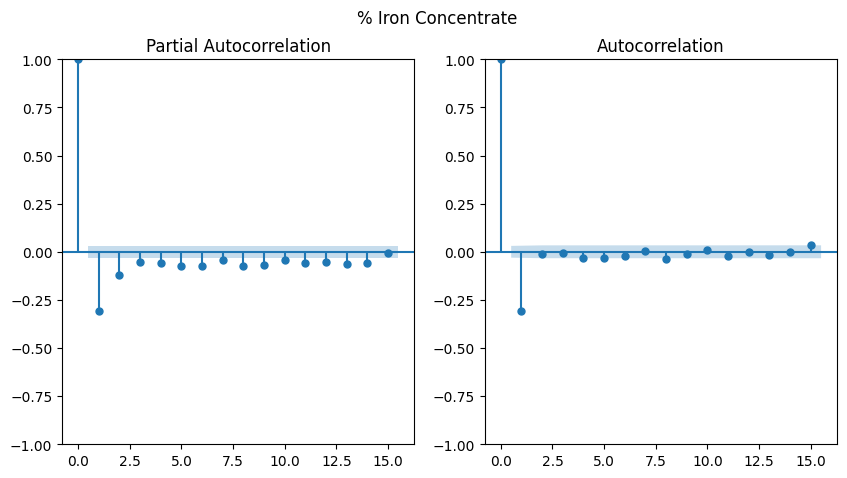

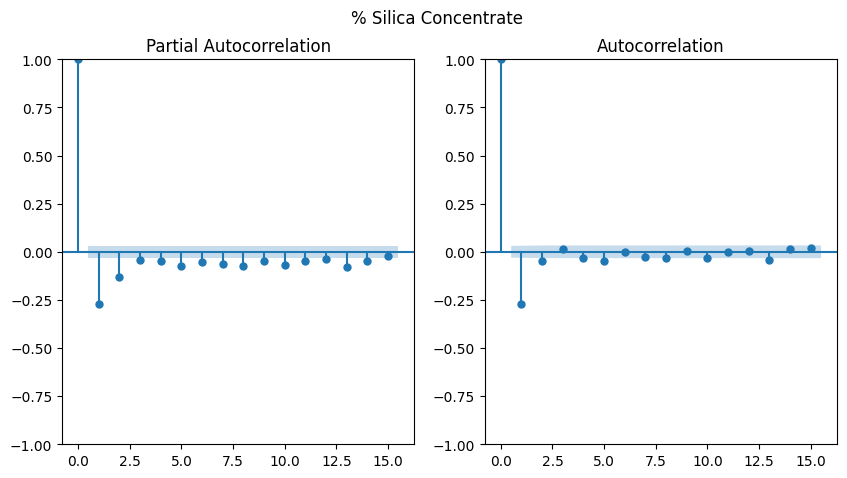

,% Iron Concentrate,% Silica Concentrate
1,0.134156,-0.177812
2,-0.080494,0.142250
3,-0.196762,0.080015
4,-0.107325,-0.017781
5,0.196762,-0.168921


In [18]:
y = pd.DataFrame([])
for i in Y.columns :
    y[i] = Y[i] - Y[i].shift(1)
y.dropna(inplace=True)

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in Y.columns :
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle(i)
    plot_pacf(y[i], lags=15, ax=ax1)
    plot_acf(y[i], lags=15, ax=ax2)
    plt.show()
    
y.head()

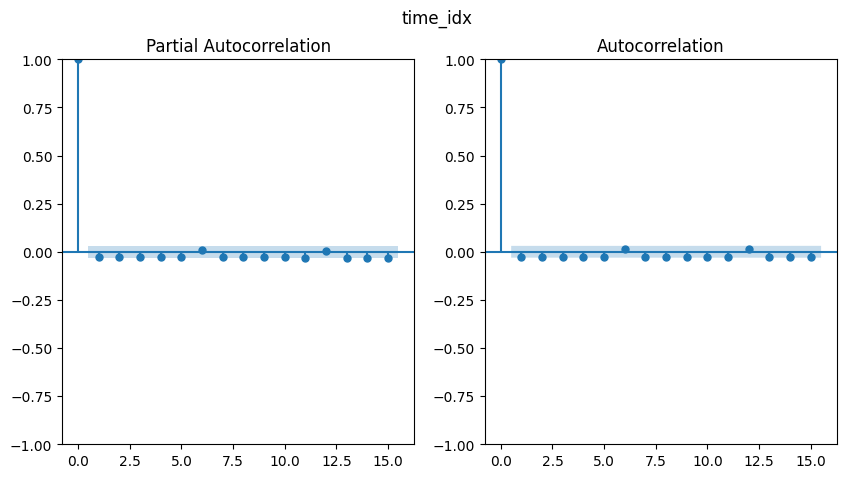

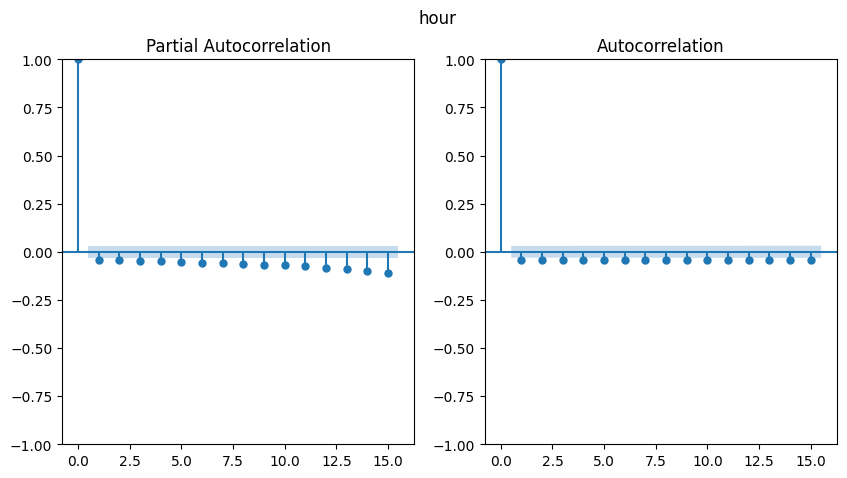

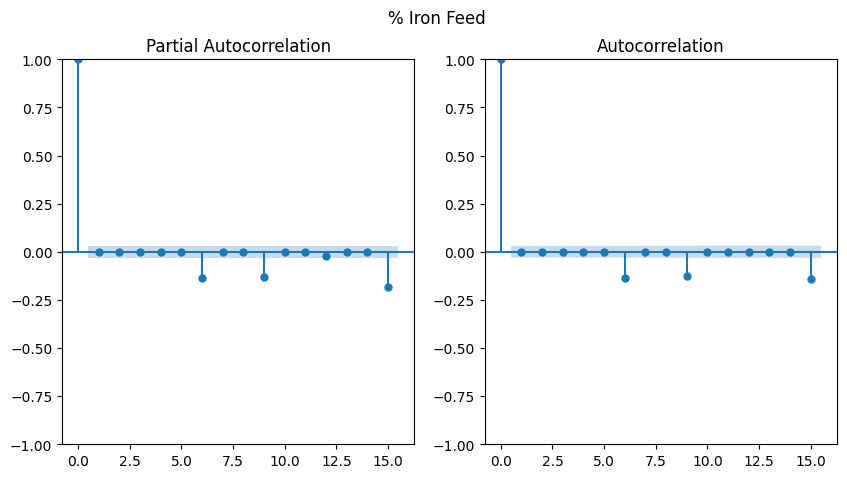

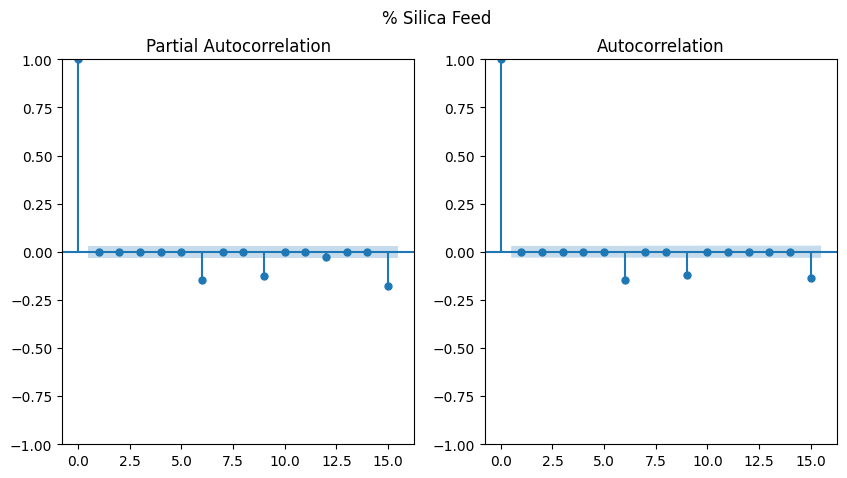

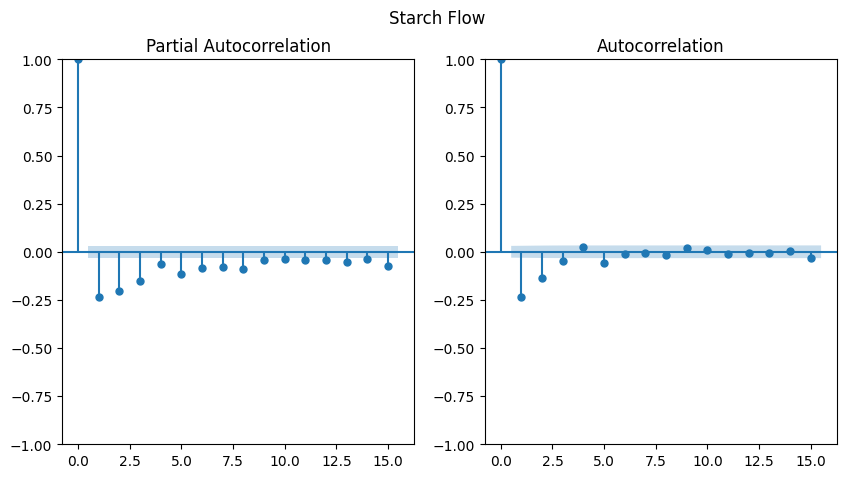

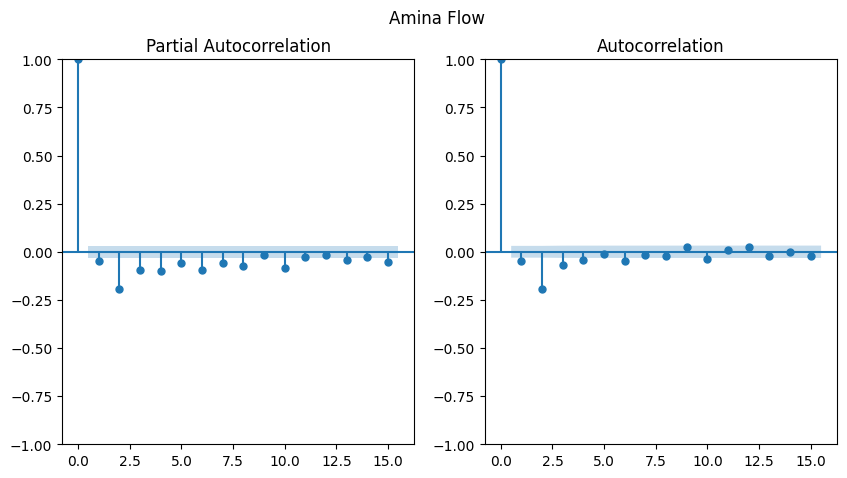

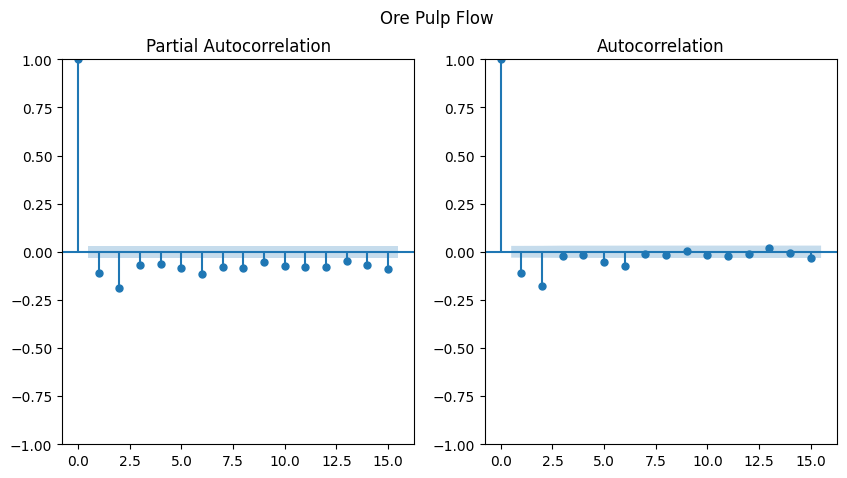

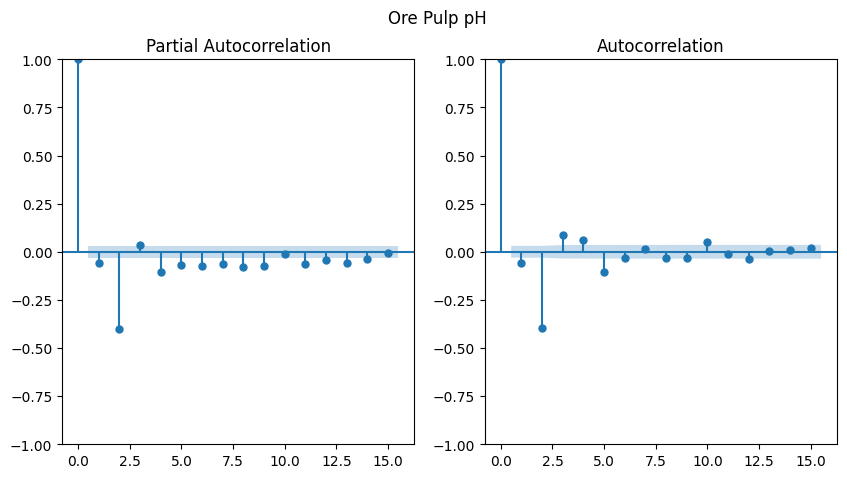

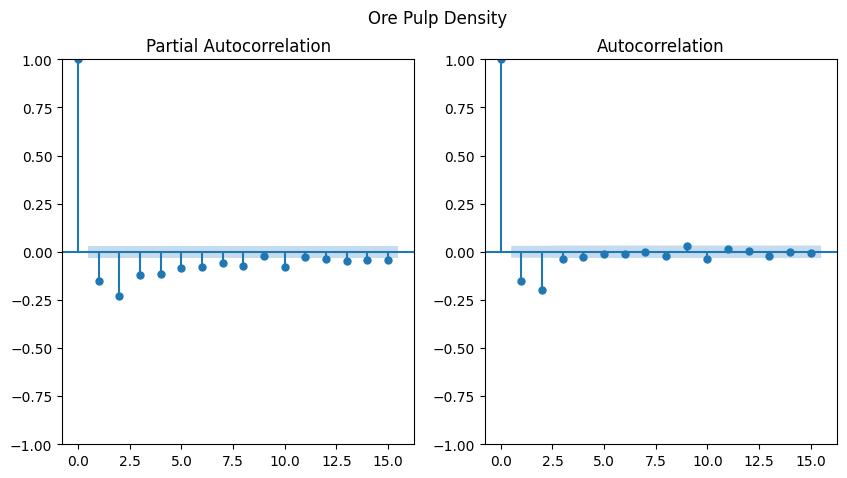

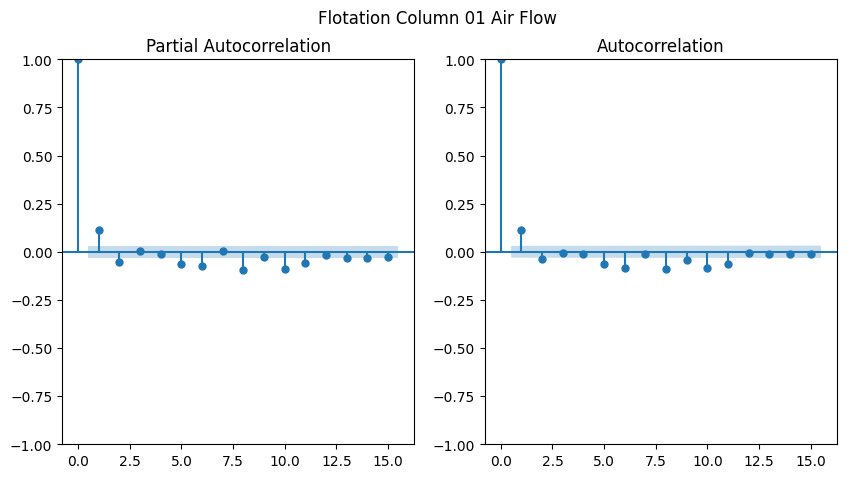

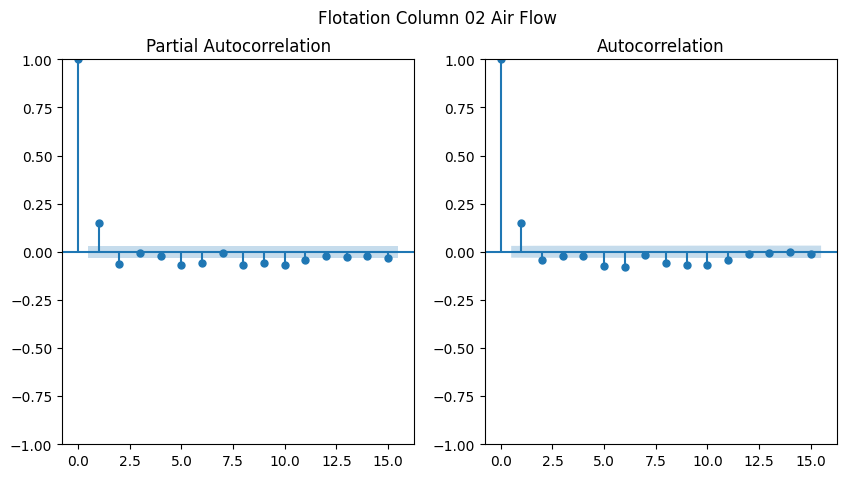

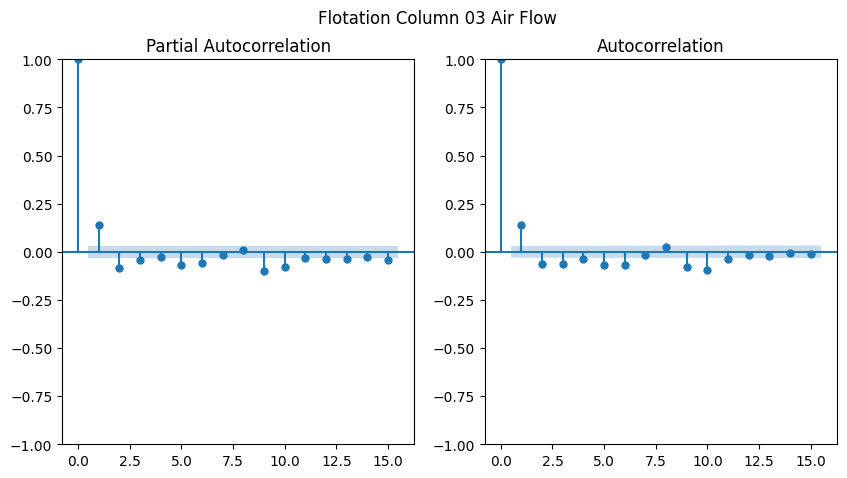

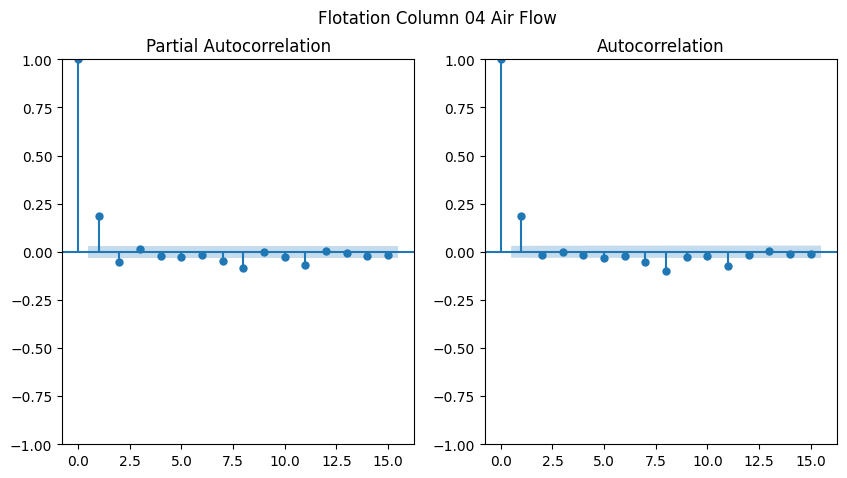

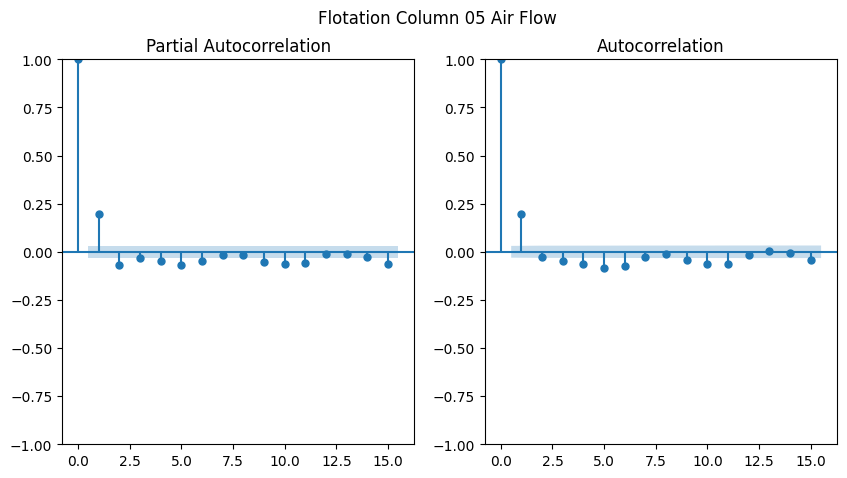

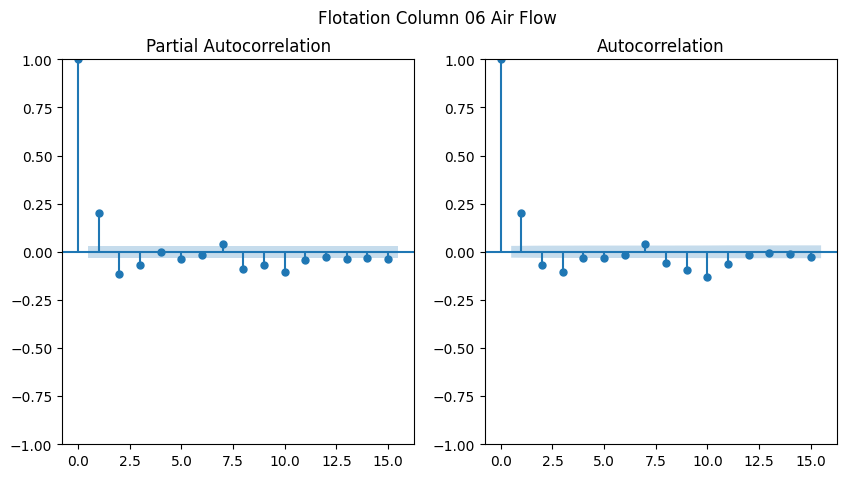

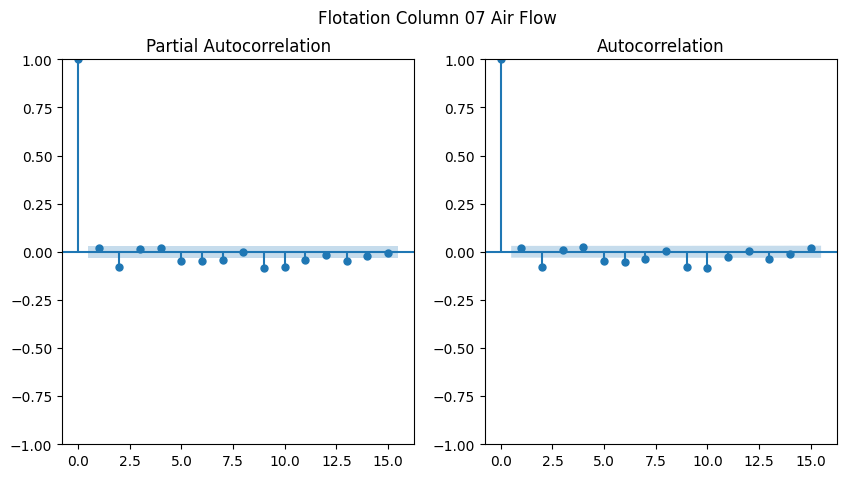

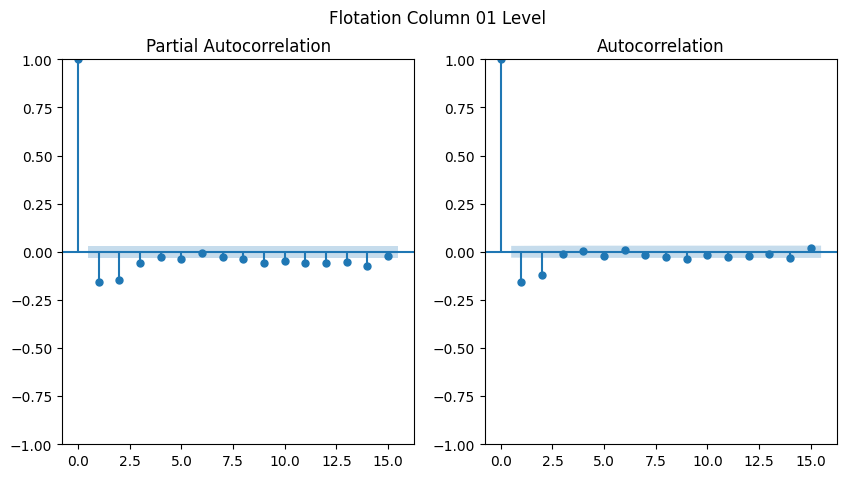

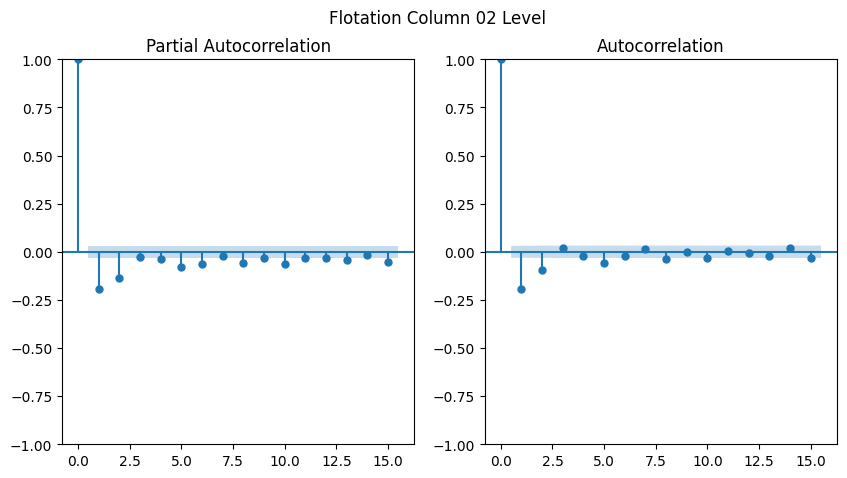

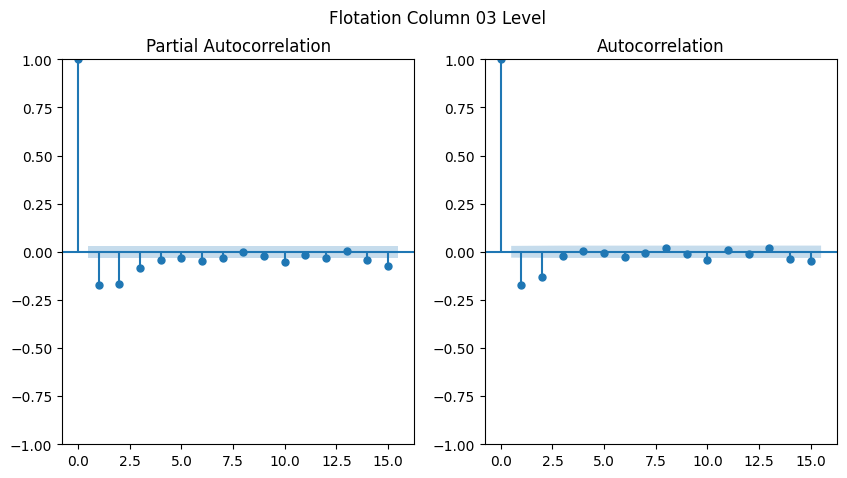

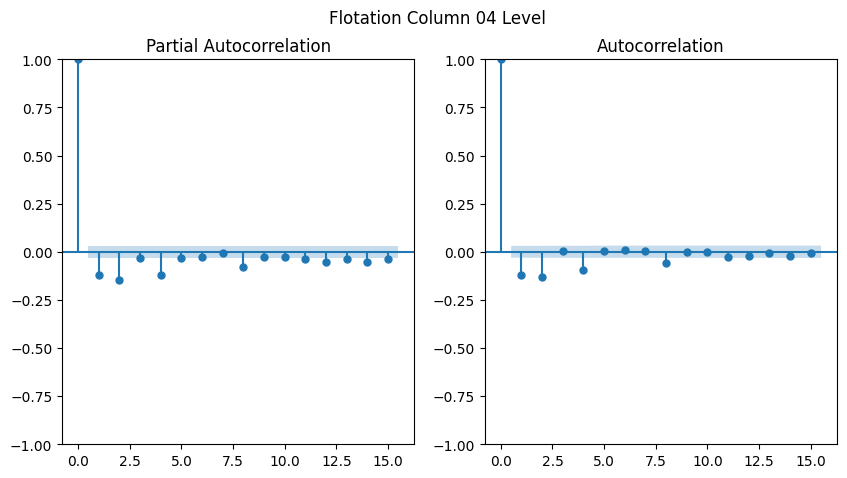

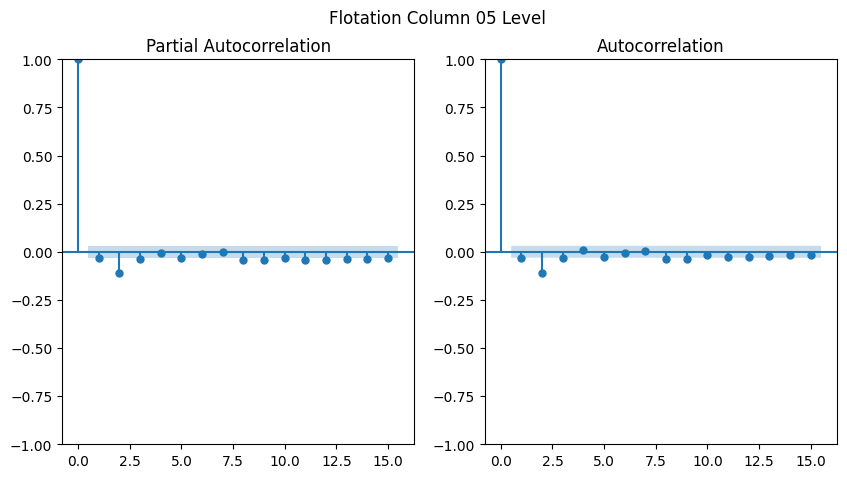

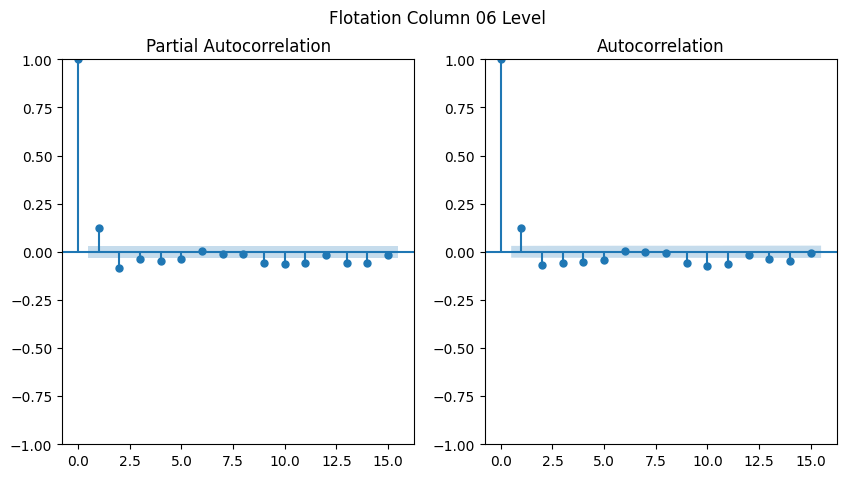

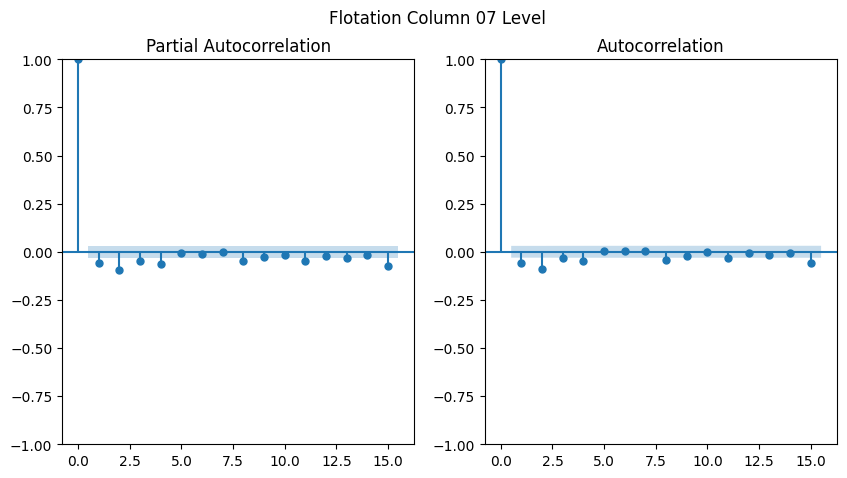

,time_idx,hour,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
1,0.0,0.144397,0.0,0.0,-0.030899,-0.496679,0.133616,0.042998,-0.968630,-0.043729,...,0.0,-0.044699,-0.011411,-0.008270,0.028930,-0.002838,0.005439,-0.094214,-0.117628,0.011783
2,0.0,0.144397,0.0,0.0,0.364265,0.653449,-0.132369,-0.215165,1.018065,0.009546,...,0.0,0.011239,0.021551,0.004907,0.005337,0.005921,0.010668,0.032135,0.059329,-0.015037
3,0.0,0.144397,0.0,0.0,-0.264547,0.015096,0.131791,-0.343334,-0.025951,0.001613,...,0.0,-0.014090,-0.011997,0.310764,0.349777,0.263265,0.566456,0.593469,0.566602,0.615299
4,0.0,0.144397,0.0,0.0,0.104415,0.317131,-0.030092,-0.456541,0.546039,-0.009894,...,0.0,0.014341,-0.002902,0.500025,0.504253,0.447891,0.723992,0.717663,0.767244,0.762617
5,0.0,0.144397,0.0,0.0,0.081939,0.025902,0.016039,0.386766,-0.012782,-0.000663,...,0.0,-0.010376,0.002617,0.012834,-0.000465,-0.002672,-0.004776,-0.003889,0.004706,0.011288


In [19]:
x = pd.DataFrame([])
for i in X.columns :
    x[i] = X[i] - X[i].shift(1)
x.dropna(inplace=True)

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in X.columns :
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle(i)
    plot_pacf(x[i], lags=15, ax=ax1)
    plot_acf(x[i], lags=15, ax=ax2)
    plt.show()
    
x.head()

# Predicting

In [20]:
data = pd.read_csv(path+'MiningProcess_Flotation_Plant_Database_hourly.csv', index_col=0)
data = data.drop(['time_idx', 'hour'],axis=1)
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.20,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,...,250.208184,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31
1,55.20,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,...,249.897572,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11
2,55.20,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,...,250.484183,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27
3,55.20,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,250.120861,...,250.157622,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36
4,55.20,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,250.013500,...,250.078639,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,49.75,23.20,3327.047776,497.211189,380.847200,9.176166,1.660871,301.565561,300.169133,299.900722,...,298.736661,397.781583,498.753311,403.858956,398.930467,502.971728,399.468911,400.559511,65.05,1.65
4093,49.75,23.20,4225.800333,508.963856,381.112889,9.387541,1.691996,300.050172,299.967839,299.906550,...,303.599269,399.928567,499.648950,399.208611,399.967122,501.624533,398.905006,400.486233,64.83,1.71
4094,49.75,23.20,2808.214692,517.748822,381.064411,9.771277,1.735647,299.814289,299.801561,299.973161,...,309.875439,399.961433,500.484917,471.827489,399.931033,500.223311,401.899806,400.556333,64.29,1.80
4095,49.75,23.20,3191.497672,492.511228,380.445006,9.782121,1.716644,300.122756,299.679472,299.927028,...,305.254558,399.601383,498.614494,836.277192,400.455389,500.406239,402.703283,401.769072,64.25,1.96


In [21]:
A = data.drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
B = data[['% Iron Concentrate', '% Silica Concentrate']]

In [22]:
A_2 = A.drop(A.index[-1:], axis=0)
B_2 = B.drop(B.index[:1], axis=0)
B_3 = B_2.reset_index(drop=True)
df = pd.concat([A_2,B_3], axis=1 )

# Size 4096

In [23]:
train = df[:4032]
test = df[4032:]

In [24]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection


pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
train_pro = pip.fit_transform(train.drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))
train_pro['% Iron Concentrate'] = train['% Iron Concentrate']
train_pro['% Silica Concentrate'] = train['% Silica Concentrate']

In [25]:
columns = train_pro.columns
test_pro = test[columns]
test_pro['% Iron Concentrate'] = test['% Iron Concentrate']
test_pro['% Silica Concentrate'] = test['% Silica Concentrate']
    

In [27]:
error =[]
VAR_model = sm.tsa.VAR(train_pro)
results = VAR_model.fit(1)
forecast = results.forecast(train_pro.values[-1:], 64)
    
a= 0
for j in range(64) :
    a += (abs(forecast[j][-1] - test_pro['% Silica Concentrate'].iloc[j]))
    
error.append(a/64)
    
error

[0.5599296078266125]

In [28]:
sum(error)/len(error)

0.5599296078266125

# Size 2048

In [29]:
batc = []

for i in range(2) :
    batc.append(data[(data.index <= 2048*(i+1) ) & (data.index >= 2048*i)])

In [30]:
batch = [0 for i in range(2)]

for i in range(2) :
    X = batc[i].drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
    Y = batc[i][['% Iron Concentrate', '% Silica Concentrate']]
    X_2 = X.drop(X.index[-1:], axis=0)
    X_3 = X_2.reset_index(drop=True)
    Y_2 = Y.drop(Y.index[:1], axis=0)
    Y_3 = Y_2.reset_index(drop=True)
    batch[i] = pd.concat([X_3,Y_3], axis=1 )

In [31]:
train = []
test = []

for i in range(2) :
    train.append(batch[i][:2016])
    test.append(batch[i][2016:])

In [32]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(2) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Iron Concentrate'] = train[i]['% Iron Concentrate']
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [33]:
test_pro = [0 for i in range(2)]

for i in range(2) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Iron Concentrate'] = test[i]['% Iron Concentrate']
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [34]:
error = []

for i in range(2) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 32)
    
    a= 0
    for j in range(32) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/32)
    
error

[0.7080638745651409, 0.5891279007960725]

In [35]:
sum(error)/len(error)

0.6485958876806066

# Size 1024

In [36]:
batc = []

for i in range(4) :
    batc.append(data[(data.index <= 1024*(i+1) ) & (data.index >= 1024*i)])

In [37]:
batch = [0 for i in range(4)]

for i in range(4) :
    X = batc[i].drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
    Y = batc[i][['% Iron Concentrate', '% Silica Concentrate']]
    X_2 = X.drop(X.index[-1:], axis=0)
    X_3 = X_2.reset_index(drop=True)
    Y_2 = Y.drop(Y.index[:1], axis=0)
    Y_3 = Y_2.reset_index(drop=True)
    batch[i] = pd.concat([X_3,Y_3], axis=1 )

In [38]:
train = []
test = []

for i in range(4) :
    train.append(batch[i][:1008])
    test.append(batch[i][1008:])

In [39]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(4) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Iron Concentrate'] = train[i]['% Iron Concentrate']
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [40]:
test_pro = [0 for i in range(4)]

for i in range(4) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Iron Concentrate'] = test[i]['% Iron Concentrate']
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [43]:
error = []

for i in range(4) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 16)
    
    a= 0
    for j in range(16) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/16)
    
error

[0.74389568008748, 0.28409998629675154, 1.1727369328016675, 0.3705026846626831]

In [44]:
sum(error)/len(error)

0.6428088209621455

# Size 512

In [45]:
batc = []

for i in range(8) :
    batc.append(data[(data.index <= 512*(i+1) ) & (data.index >= 512*i)])

In [46]:
batch = [0 for i in range(8)]

for i in range(8) :
    X = batc[i].drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
    Y = batc[i][['% Iron Concentrate', '% Silica Concentrate']]
    X_2 = X.drop(X.index[-1:], axis=0)
    X_3 = X_2.reset_index(drop=True)
    Y_2 = Y.drop(Y.index[:1], axis=0)
    Y_3 = Y_2.reset_index(drop=True)
    batch[i] = pd.concat([X_3,Y_3], axis=1 )

In [47]:
train = []
test = []

for i in range(8) :
    train.append(batch[i][:504])
    test.append(batch[i][504:])

In [48]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(8) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Iron Concentrate'] = train[i]['% Iron Concentrate']
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [49]:
test_pro = [0 for i in range(8)]

for i in range(8) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Iron Concentrate'] = test[i]['% Iron Concentrate']
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [50]:
error = []

for i in range(8) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 8)
    
    a= 0
    for j in range(8) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/8)
    
error

[0.6933211438347034,
 0.776601724744147,
 0.3483659889459525,
 0.2971880303706602,
 0.709528725730675,
 0.8219612704453683,
 0.7380912509946198,
 0.6165901268098559]

In [51]:
sum(error)/len(error)

0.6252060327344977

# Size 256

In [52]:
batc = []

for i in range(16) :
    batc.append(data[(data.index <= 256*(i+1) ) & (data.index >= 256*i)])

In [53]:
batch = [0 for i in range(16)]

for i in range(16) :
    X = batc[i].drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
    Y = batc[i][['% Iron Concentrate', '% Silica Concentrate']]
    X_2 = X.drop(X.index[-1:], axis=0)
    X_3 = X_2.reset_index(drop=True)
    Y_2 = Y.drop(Y.index[:1], axis=0)
    Y_3 = Y_2.reset_index(drop=True)
    batch[i] = pd.concat([X_3,Y_3], axis=1 )

In [54]:
train = []
test = []

for i in range(16) :
    train.append(batch[i][:252])
    test.append(batch[i][252:])

In [55]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(16) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Iron Concentrate'] = train[i]['% Iron Concentrate']
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [56]:
test_pro = [0 for i in range(16)]

for i in range(16) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Iron Concentrate'] = test[i]['% Iron Concentrate']
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [57]:
error = []

for i in range(16) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 4)
    
    a= 0
    for j in range(4) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/4)
    
error

[0.9267090958043654,
 0.5751811355220527,
 0.19121748767819846,
 1.2359636125169222,
 0.4409280704837881,
 0.3776348613237991,
 1.4792488159984845,
 0.12393482540705408,
 0.7185936270468154,
 1.733085103578831,
 0.18688882008884866,
 1.1821855962632,
 0.32985314252552156,
 1.094666129111659,
 0.7797069177059004,
 0.19961730741215739]

In [58]:
sum(error)/len(error)

0.7234634092792248

# Size128

In [59]:
batc = []

for i in range(32) :
    batc.append(data[(data.index <= 128*(i+1) ) & (data.index >= 128*i)])

In [60]:
batch = [0 for i in range(32)]

for i in range(32) :
    X = batc[i].drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
    Y = batc[i][['% Iron Concentrate', '% Silica Concentrate']]
    X_2 = X.drop(X.index[-1:], axis=0)
    X_3 = X_2.reset_index(drop=True)
    Y_2 = Y.drop(Y.index[:1], axis=0)
    Y_3 = Y_2.reset_index(drop=True)
    batch[i] = pd.concat([X_3,Y_3], axis=1 )

In [61]:
train = []
test = []

for i in range(32) :
    train.append(batch[i][:126])
    test.append(batch[i][126:])

In [62]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(32) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Iron Concentrate'] = train[i]['% Iron Concentrate']
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [63]:
test_pro = [0 for i in range(32)]

for i in range(32) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Iron Concentrate'] = test[i]['% Iron Concentrate']
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [64]:
error = []

for i in range(32) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 2)
    
    a= 0
    for j in range(2) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/2)
    
error

[0.37047715971572037,
 0.8084582876007285,
 0.4626685360492011,
 0.2324981822759975,
 0.5729268872965054,
 0.19332241791718685,
 0.5031819840303215,
 0.20860368212142621,
 0.7001942411427811,
 0.7201968996518233,
 0.48882586626190916,
 0.22142961228824276,
 0.0665177519543394,
 0.7806801257069869,
 0.40842797121969854,
 0.05814601954268128,
 0.05276787539030181,
 0.8806960540906948,
 0.5491839744116876,
 1.030842385107714,
 0.15373416508798177,
 0.13173407772890278,
 0.4281148484050422,
 1.6489292926026884,
 0.17781298948347057,
 0.2516375177600594,
 0.2094753566244878,
 1.9629610130450803,
 0.06130437522335341,
 0.8652253961045973,
 0.33994617361369417,
 0.1813659811629691]

In [65]:
sum(error)/len(error)

0.491321471894321

# Size64

In [66]:
batc = []

for i in range(64) :
    batc.append(data[(data.index <= 64*(i+1) ) & (data.index >= 64*i)])

In [67]:
batch = [0 for i in range(64)]

for i in range(64) :
    X = batc[i].drop(['% Iron Concentrate', '% Silica Concentrate'], axis = 1)
    Y = batc[i][['% Iron Concentrate', '% Silica Concentrate']]
    X_2 = X.drop(X.index[-1:], axis=0)
    X_3 = X_2.reset_index(drop=True)
    Y_2 = Y.drop(Y.index[:1], axis=0)
    Y_3 = Y_2.reset_index(drop=True)
    batch[i] = pd.concat([X_3,Y_3], axis=1 )

In [68]:
train = []
test = []

for i in range(64) :
    train.append(batch[i][:62])
    test.append(batch[i][62:])

In [69]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(64) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Iron Concentrate'] = train[i]['% Iron Concentrate']
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [70]:
test_pro = [0 for i in range(64)]

for i in range(64) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Iron Concentrate'] = test[i]['% Iron Concentrate']
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [71]:
error = []

a= 0
for i in range(64) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 2)
    
    a= 0
    for j in range(2) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/2)
    
error

ValueError: x contains one or more constant columns. Column(s) 11, 12 are constant. Adding a constant with trend='c' is not allowed.

In [ ]:
sum(error)/len(error)